# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Computing and visualization of precipitation linear trends during the observed period (1980-2014)

07/07/2021

**J. Baño-Medina** ([Santander Meteorology Group](http://meteo.unican.es), Instituto de Física de Cantabria, CSIC-UC, Santander, Spain)

We present an illustrative example to use the climate4R framework to depict the observed linear trends and the time series of precipitation anomalies over a selected time period for the W5E5 observational dataset. North America is used as an example target region. Indications are also provided to apply the methodology to other variables, such as temperature.

### Load packages

This notebook relies on several climate4R packages. We start by extending the Java memory allocation, which will be used by `loadeR`

In [ ]:
options(java.parameters = "-Xmx8g")
library(loadeR)
library(transformeR)
library(visualizeR) # spatialPlot
library(geoprocessoR)
library(climate4R.indices) # linearTrend

Along with other libraries, namely:

 * `magrittr` is used to pipe (%>%) sequences of data operations
 * `gridExtra` provides plotting functionalities
 * `sp` and `rgdal` provide geospatial tools
 * `RColorBrewer` provides color palettes

In [ ]:
library(magrittr)
library(sp)
library(RColorBrewer)
library(rgdal) # readOGR

### Load static data

We will load the polygons of the IPCC [reference regions v4](https://github.com/IPCC-WG1/Atlas/tree/main/reference-regions):

In [3]:
regs <- get(load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda")) %>% as("SpatialPolygons")

In this notebook we will focus on a set of regions in North America. We will use the following character vector of the target region names to select them. Change it accordingly to adapt this notebook for other regions.

In [4]:
regs.area <- c("NWN", "NEN", "WNA", "CNA","ENA","NCA") # North America regions

We can now extract the subset of regions and show their outline as follows:

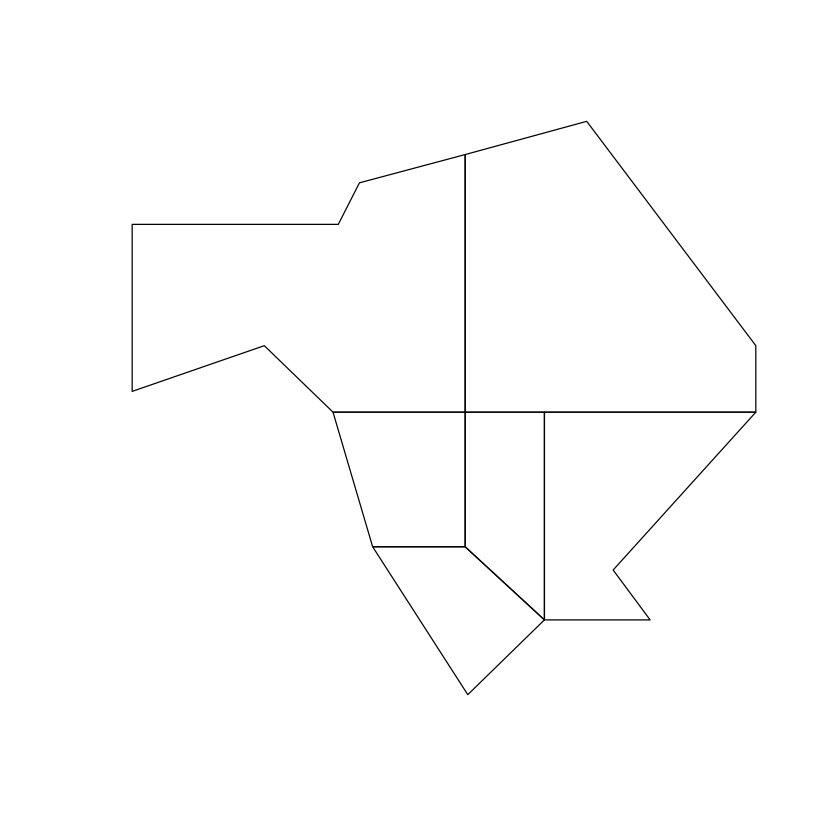

In [5]:
regs <- regs[regs.area]
plot(regs)

We load also the coastlines, to be used in the spatial maps below. These are available in the [auxiliary-material](https://github.com/IPCC-WG1/Atlas/tree/main/notebooks/auxiliary-material) folder:

In [6]:
coast <- readOGR("auxiliary-material/WORLD_coastline.shp") 

OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/Atlas/notebooks/auxiliary-material/WORLD_coastline.shp", layer: "WORLD_coastline"
with 127 features
It has 2 fields


### Load observations from the User Data Gateway

> This section takes long to execute due to intensive remote data loading. See the next section ([Load data from file](#Load-data-from-file)) to load these data from a local copy available in the repository and continue with the notebook operations.

The [Santander Climate Data Service](https://www.scds.es) (SCDS) archives and provides access to a variety of climate datasets and contributes to international infrastructures, serving e.g. as data node for the Earth System Grid Federation (ESGF) or the IPCC Data Distribution Center (IPCC-DDC). This service is maintained by the [Santander Meteorology Group](http://meteo.unican.es) (University of Cantabria - CSIC) and includes a THREDDS Data Server for remote data access with seamless integration with the climate4R framework for climate data postprocessing. This integration, the User Data Gateway (UDG), is handled by the [climate4R.UDG](https://github.com/SantanderMetGroup/climate4R.UDG) package, loaded automatically by the [loadeR](https://github.com/SantanderMetGroup/loadeR) package, which provides user-friendly access to a variety of remote data sources.

To load data stored in the User Data Gateway (similar to loading data from a local directory), we first list the available datasets with function `UDG.datasets`:

In [7]:
UDG.datasets()$OBSERVATIONS

Label names are returned, set argument full.info = TRUE to get more information



[1] "WATCH_WFDEI"            "PIK_Obs-EWEMBI"         "E-OBS_v14_0.50regular" 
 [4] "E-OBS_v14_0.44rotated"  "E-OBS_v14_0.25regular"  "E-OBS_v14_0.22rotated" 
 [7] "E-OBS_v17_0.50regular"  "E-OBS_v17_0.44rotated"  "E-OBS_v17_0.25regular" 
[10] "E-OBS_v17_0.22rotated"  "E-OBS_v21e_0.10regular" "UC-Spain02_11"         
[13] "UC-Spain02_22"          "UC-Spain02_44"          "GPCCmon"               
[16] "GPCC"                   "GPCPmon"                "GPCP"                  
[19] "CRU-TS"                 "BEST"                   "BESTmon"               
[22] "W5E5"

We see that, among others, the W5E5 dataset ([Lange, 2019](https://doi.org/10.5880/pik.2019.023)) is available from the UDG. This dataset is global, but we can load just the region of interest. In this case, we provide the limits for a North American lon-lat window:

In [8]:
lonLim <- c(168.0, -50)
latLim <- c(2.2, 85)

We will also set the analysis period to 1980-2014:

In [9]:
years <- 1980:2014

You can check the available variables in a dataset and other basic information using the dataInventory function.
```r
dataInventory("W5E5")
```

The standard names used in climate4R (passed to function `loadGridData`) can be consulted as follows:

```r
C4R.vocavulary()
```

The variable of interest in this notebook is precipitation:

In [10]:
var <- "pr"

To load W5E5 we would just input the corresponding label to the `dataset` argument in `loadGridData`. In order to save memory, we load the data year by year in a loop and perform annual aggregation in each iteration. After using `bindGrid` (to join the yearly data sets) we end up with a climate4R Grid object containing yearly averages for the region selected. The following piece of code takes about 1 minute per year loaded (depends on your network connection speed). 

```R
grid.list <- list()
for (year in years){
    message(" ** Reading year ", year)
    grid.list[[as.character(year)]] <- loadGridData(
        dataset = "W5E5", var = var,
        latLim = latLim, lonLim = lonLim, years = year
    ) %>%
    aggregateGrid(aggr.y = list(FUN = "mean", na.rm = TRUE)) 
}
grid <- bindGrid(grid.list, dimension = "time")                                         
```

This operation takes a long time, therefore it is convenient to save the resulting data. We can export the final dataset to NetCDF using the `loadeR.2nc` library, which provides the function `grid2nc`.

```R
library(loadeR.2nc)
grid2nc(grid, NetCDFOutFile = "auxiliary-material/W5E5_NorthAmerica_pr_1980-2014_yearly.nc4")
```

The resulting NetCDF is available as auxiliary material in this repository, therefore the previous data loading step can be skipped.

### Load data from file

Skip this section if you sucessfully loaded your data from the User Data Gateway. For a fast loading of the required data, you can use a copy of the yearly averaged precipitation available in the `auxiliary-material` folder:

In [11]:
grid <- loadGridData("auxiliary-material/W5E5_NorthAmerica_pr_1980-2014_yearly.nc4", var = "pr")

[2021-08-08 08:03:08] Defining geo-location parameters

[2021-08-08 08:03:08] Defining time selection parameters

[2021-08-08 08:03:08] Retrieving data subset ...

[2021-08-08 08:03:11] Done



### Plot climatology

We can start by plotting the climatology of precipitation for the selected period and region. We define the geographical projection (WGS84) the same as the reference regions.

In [12]:
grid <- setGridProj(grid = grid, proj = proj4string(regs))

We compute the climatology by calling the `climatology` function and then use `spatialPlot` from library `visualizeR` to depict it. Note that we introduce the IPCC regions of interest in the `sp.layout` argument.

[2021-08-08 08:03:11] - Computing climatology...

[2021-08-08 08:03:11] - Done.



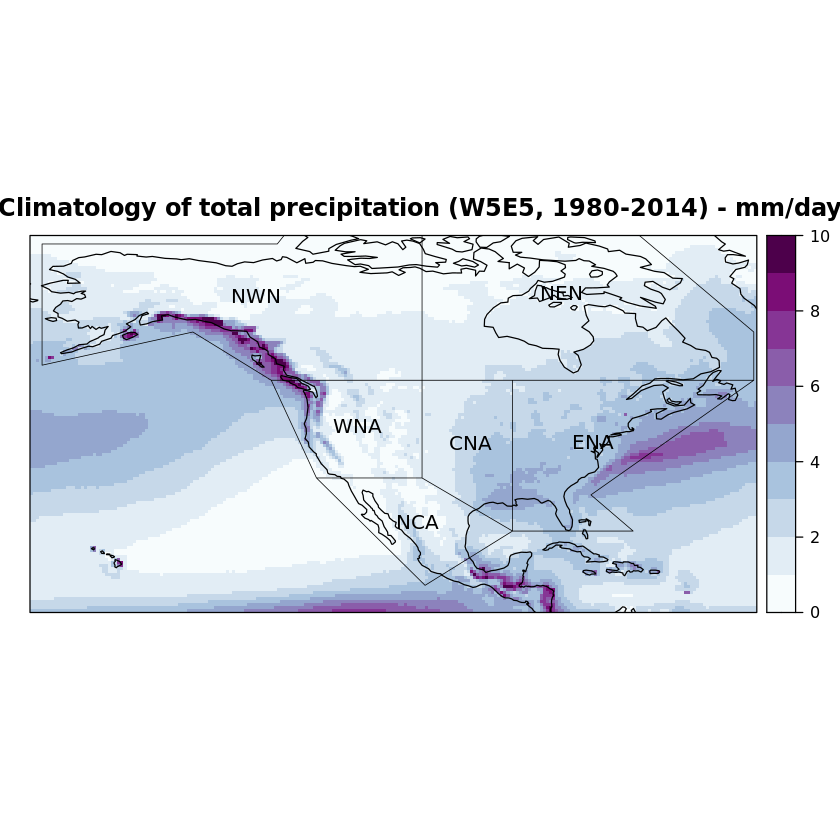

In [13]:
spatialPlot(climatology(grid),
            at = seq(0, 10, 1), 
            set.min = 0,
            set.max = 10,
            backdrop.theme = "coastline",
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette(),
            main = paste0("Climatology of total precipitation (W5E5, ", min(years), "-", max(years), ") - mm/day"),
            sp.layout = list(
                list(regs, first = FALSE, lwd = 0.6),
                list("sp.text", coordinates(regs), names(regs), first = FALSE, cex = 1)
))

We can use the `overGrid` function to mask the values outside the IPCC regions of interest to this use-case.

In [14]:
grid %<>% overGrid(regs)

Compare the resulting plot (same code as above):

[2021-08-08 08:03:13] - Computing climatology...

[2021-08-08 08:03:14] - Done.



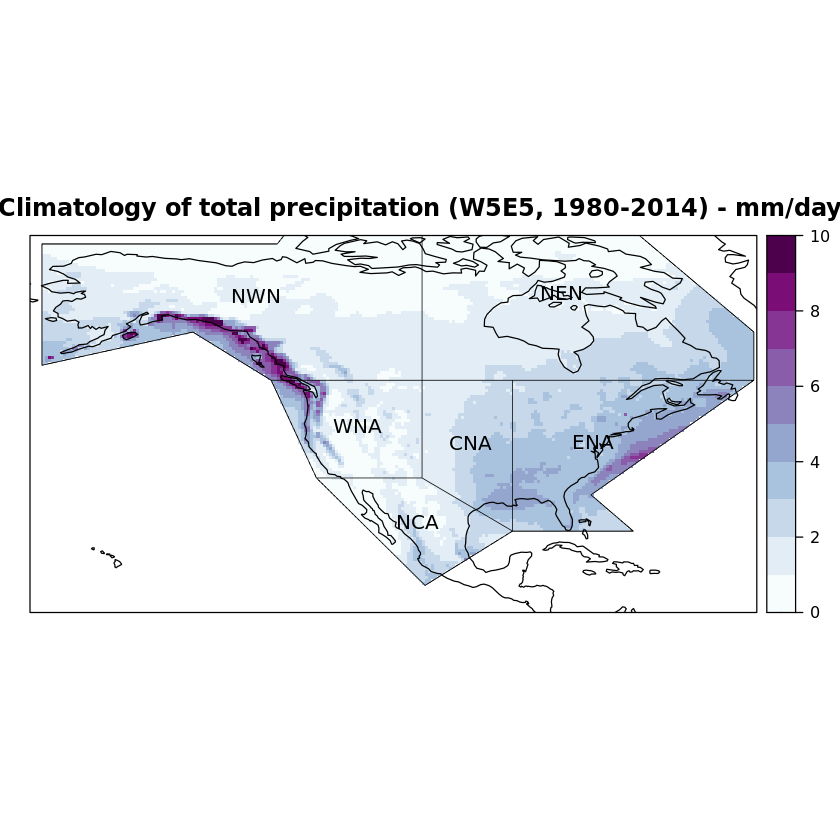

In [15]:
spatialPlot(climatology(grid),
            at = seq(0, 10, 1), 
            set.min = 0,
            set.max = 10,
            backdrop.theme = "coastline",
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette(),
            main = paste0("Climatology of total precipitation (W5E5, ", min(years), "-", max(years), ") - mm/day"),
            sp.layout = list(
                list(regs, first = FALSE, lwd = 0.6),
                list("sp.text", coordinates(regs), names(regs), first = FALSE, cex = 1)
))

### Compute and plot trends

Now, trends can be computed by means of the `linearTrend` function, which fits a linear model at gridbox level and returns all the involved statistics, including the p-value of the estimated slope. We subset the slope ("b") among all the statistics returned, by calling `subsetGrid`. 

In [16]:
trendGrid <- linearTrend(grid) %>% subsetGrid(var = "b")

We could save these climate products as NetCDF files using the `loadeR.2nc` library.

```R
grid2nc(trendGrid, NetCDFOutFile = "trends.nc4")
```

We rely again on `spatialPlot` from visualizeR, to show the map of trends.

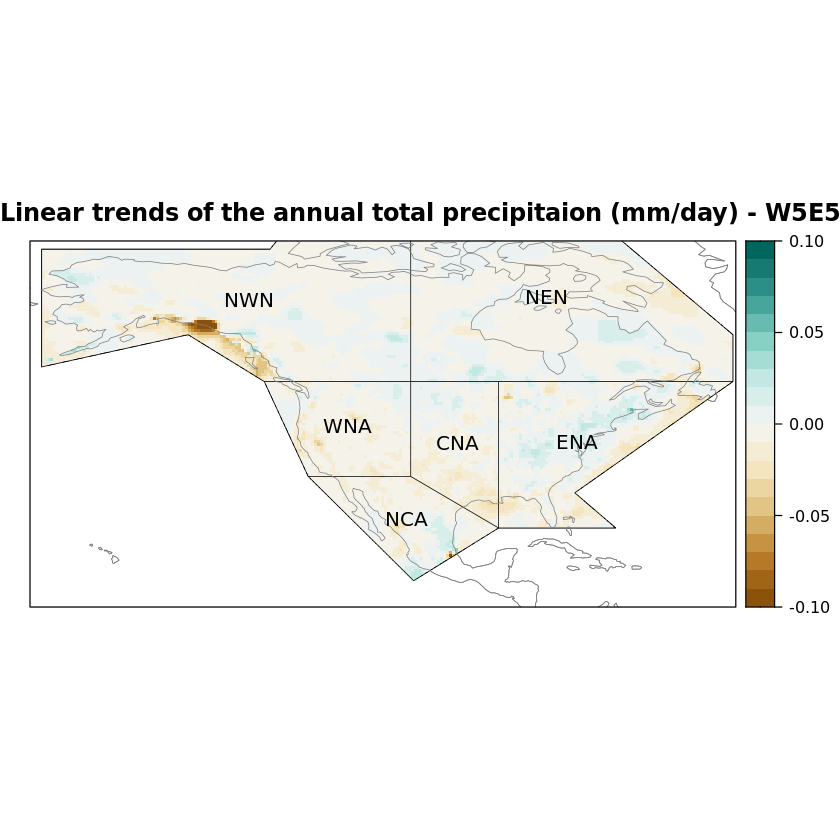

In [17]:
spatialPlot(trendGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = seq(-0.1, 0.1, 0.01), 
            set.min = -0.1,
            set.max = 0.1,
            main = paste("Linear trends of the annual total precipitaion (mm/day) - W5E5"),
            sp.layout = list(  
            list(regs, first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs), names(regs), first = FALSE, cex = 1)
))

#### Trend significance

Next, we show how to add trend statistical significance information as a hatching. For this purpose, we repeat the process but retrieving the p-values of the linear trends (instead of the slopes, as above). Therefore we subset the variable `pval` using `subsetGrid`. Finally, we convert the p-values to a binary field using a threshold of 0.1. In the resulting binary field, 0 indicates that the trend is significant and 1 means non-significant.

In [18]:
pvalGrid <- linearTrend(grid) %>% subsetGrid(var = "pval")
pvalGrid <- binaryGrid(pvalGrid, threshold = 0.1, condition = "GT")

We can check the resulting grid by plotting the map.

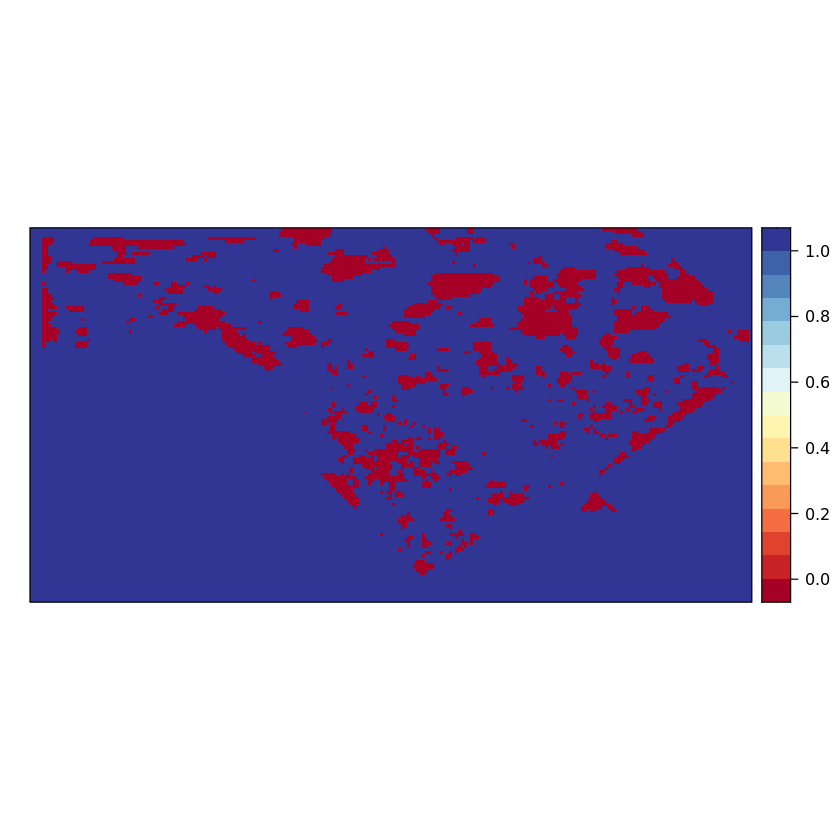

In [19]:
spatialPlot(pvalGrid)

We build (`binaryGrid`) and apply (`gridArithmetics`) a mask to avoid R misusing NaN data out of the regions of interest when calculating the p-values.

In [20]:
mask <- binaryGrid(climatology(grid),condition = "GE", threshold = 0, values = c(NA,1))
pvalGrid <- gridArithmetics(pvalGrid, mask)

[2021-08-08 08:03:30] - Computing climatology...

[2021-08-08 08:03:30] - Done.



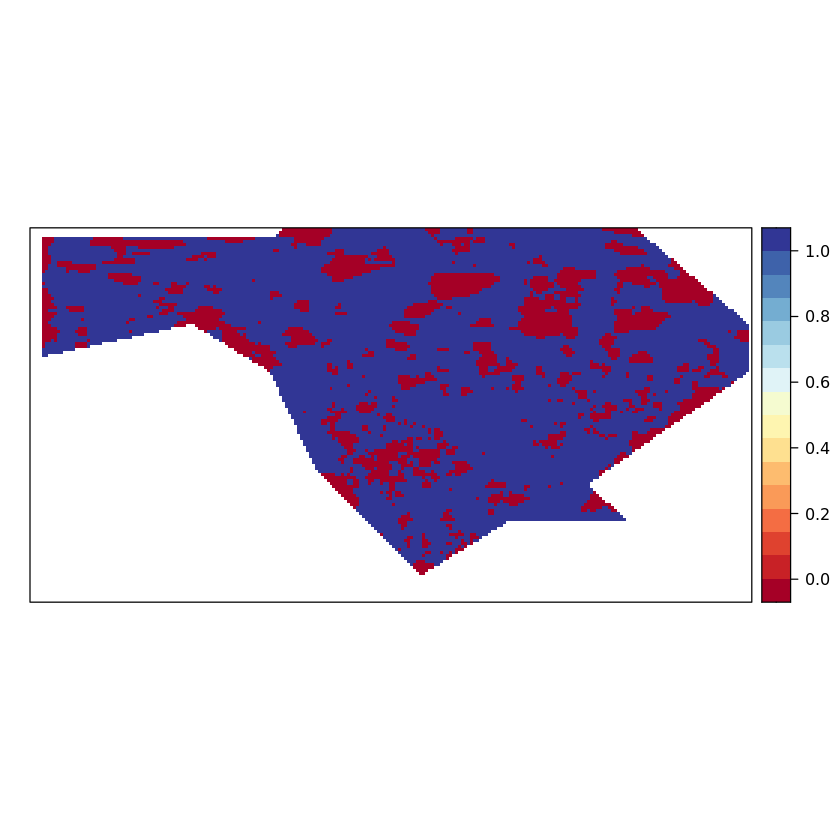

In [21]:
spatialPlot(pvalGrid)

We can now use the p-values computed above to add a hatching pattern over the trend maps. To do so, we encapsulate the function `map.hatching` in a 2-way loop that corresponds to each line in a 'x' symbol. An 'x' would be associated whenever the condition is fullfilled, in our case whenever at least half the gridpoints of the upscaled grid are non-significant (i.e., 0-valued in the binary p-value object, `pvalGrid`). We use the `mean` fuction as the upscaling aggregation function, moving from a spatial resolution of half a degree in the trends field, to 2 degrees in the hatching. The upscaled (hatching) grid resolution is based on the `density` parameter of function `map.hatching`. In our case `density = 4` and, therefore, the corresponding spatial resolution is 4 x 0.5 degrees = 2 degrees.

In [22]:
hatching.lines <- lapply(c("45","-45"), FUN = function(angle) {
  c(map.hatching(clim = climatology(pvalGrid), 
                 threshold = 0.5, 
                 condition = "GE", 
                 density = 4,
                 angle = angle, coverage.percent = 50,
                 upscaling.aggr.fun = list(FUN = "mean", na.rm = TRUE)
  ), 
  "which" = 1, lwd = 0.5)
})

[2021-08-08 08:03:31] - Computing climatology...

[2021-08-08 08:03:31] - Done.

[2021-08-08 08:03:32] - Computing climatology...

[2021-08-08 08:03:33] - Done.



We rely again on `spatialPlot` from visualizeR to plot the trend maps and include the p-value as hatching as a member of the `sp.layout` argument list.

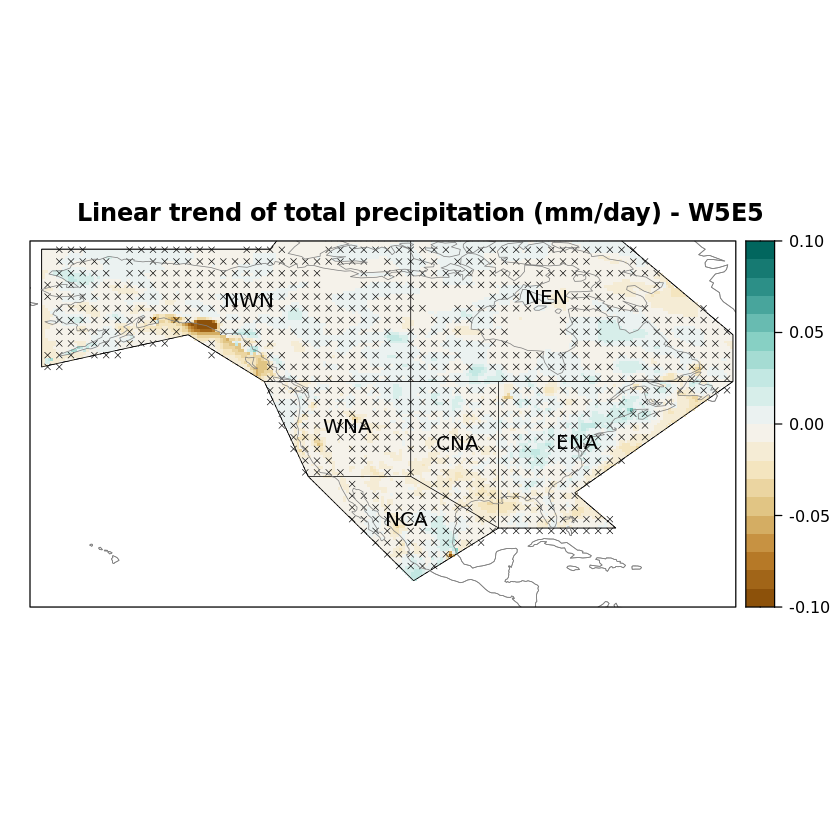

In [23]:
spatialPlot(trendGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = seq(-0.1, 0.1, 0.01), 
            set.min = -0.1,
            set.max = 0.1,
            main = paste("Linear trend of total precipitation (mm/day) - W5E5"),
            sp.layout = list(
              hatching.lines[[1]],
              hatching.lines[[2]],  
              list(regs, first = FALSE, lwd = 0.6),
              list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
              list("sp.text", coordinates(regs), names(regs), first = FALSE, cex = 1)
            )
)

### Anomaly time series

Finally, we can have a look at the trends in average time series for each IPCC region. For this purpose, we loop over the IPCC regions to crop the field for each particular region. This will facilitate the spatial averaging over each region. To do so we rely on function `overGrid`.

In [24]:
grid.regs <- lapply(names(regs), function(r) overGrid(grid, regs[r]))

Let's check the corresponding map e.g. for NWN

[2021-08-08 08:03:41] - Computing climatology...

[2021-08-08 08:03:41] - Done.



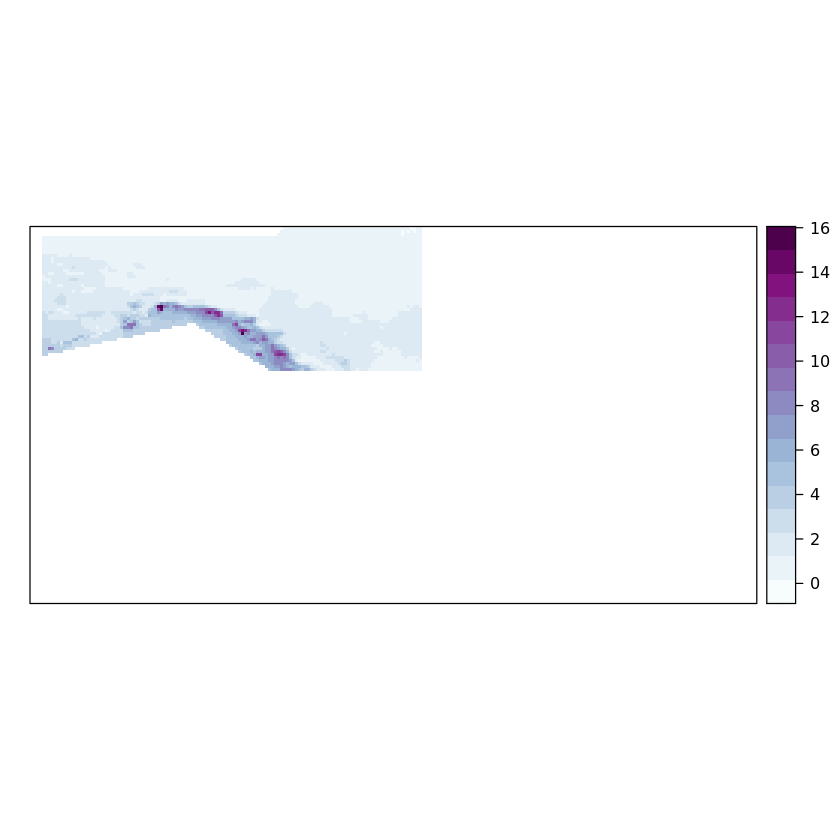

In [25]:
spatialPlot(climatology(grid.regs[["NWN"]]), 
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette()
)

We compute the anomalies by calling `scaleGrid` of `transformeR` and setting the argument `type = center` to substract the mean from the temporal series. Previously, we call `aggregateGrid` over the list of IPCC objets to average spatially over each region and, therefore, output the temporal series for every North American IPCC region.

In [ ]:
spatial.mean <- function(grid) aggregateGrid(grid, aggr.spatial = list(FUN = "mean", na.rm = TRUE)) %>% scaleGrid(type = "center")
grid.anom <- lapply(grid.regs, spatial.mean)  

Finally, we will use `temporalPlot` (library `visualizeR`) to show these anomaly time series. `temporalPlot` uses the names of the grid objects to create the legend, region names in this case: 

In [27]:
names(grid.anom)

[1] "NWN" "NEN" "WNA" "CNA" "ENA" "NCA"

If we'd like to add the trend value to the legend, we only need to paste these values to the names of object `grid.anom` before calling `temporalPlot`.

In [ ]:
trend.val <- lapply(1:length(grid.anom), FUN = function(x) {
    aux <- linearTrend(grid.anom[[x]]) %>% subsetGrid(var = "b")
    round(aux$Data[1], digits = 3)
})
names(grid.anom) <- sprintf("%s (%g mm/day/yr)", names(grid.anom), trend.val)

In [29]:
names(grid.anom)

[1] "NWN (-0.004 mm/day/yr)" "NEN (-0.001 mm/day/yr)" "WNA (-0.005 mm/day/yr)"
[4] "CNA (-0.006 mm/day/yr)" "ENA (-0.001 mm/day/yr)" "NCA (-0.003 mm/day/yr)"

pad applied on the interval: year

pad applied on the interval: year

pad applied on the interval: year

pad applied on the interval: year

pad applied on the interval: year

pad applied on the interval: year



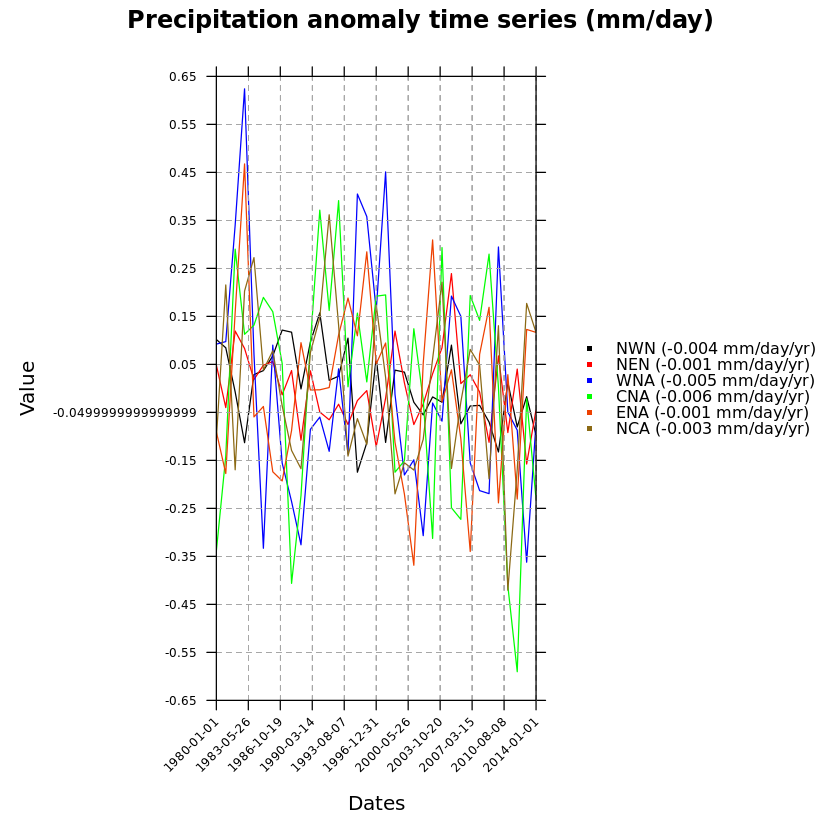

In [30]:
temporalPlot(grid.anom,
               xyplot.custom = list(
                 main = "Precipitation anomaly time series (mm/day)", ylim=c(-0.65, 0.65)
               ))      

### Session info

In [31]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16            RColorBrewer_1.1-2      sp_1.4-5               
 [4] magrittr_2.0.1          climate4R.indices_0.2.0 geoprocessoR_0.2.0     
 [7] visualizeR_1.6.1        transformeR_2.1.3       loadeR_1.7.1           
[10] climate4R.UDG_0.2.3     loadeR.java_1.1.1  